* Requisite imports + models

In [1]:
# importing all 
import numpy as np 
import pandas as pd 
import seaborn as sns 
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.svm import SVR
from xgboost import XGBRegressor
from sklearn.linear_model import Ridge
from sklearn.linear_model import ElasticNet
from sklearn.linear_model import SGDRegressor
from sklearn.linear_model import BayesianRidge
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

First, we format df and try to drop nulls/correct and scale the data

In [2]:
#load data
df = pd.read_csv('data.csv')
df.head()

,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,sqft_above,sqft_basement,yr_built,yr_renovated,street,city,statezip,country
0,2014-05-02 00:00:00,313000.0,3.0,1.50,1340,7912,1.5,0,0,3,1340,0,1955,2005,18810 Densmore Ave N,Shoreline,WA 98133,USA
1,2014-05-02 00:00:00,2384000.0,5.0,2.50,3650,9050,2.0,0,4,5,3370,280,1921,0,709 W Blaine St,Seattle,WA 98119,USA
2,2014-05-02 00:00:00,342000.0,3.0,2.00,1930,11947,1.0,0,0,4,1930,0,1966,0,26206-26214 143rd Ave SE,Kent,WA 98042,USA
3,2014-05-02 00:00:00,420000.0,3.0,2.25,2000,8030,1.0,0,0,4,1000,1000,1963,0,857 170th Pl NE,Bellevue,WA 98008,USA
4,2014-05-02 00:00:00,550000.0,4.0,2.50,1940,10500,1.0,0,0,4,1140,800,1976,1992,9105 170th Ave NE,Redmond,WA 98052,USA


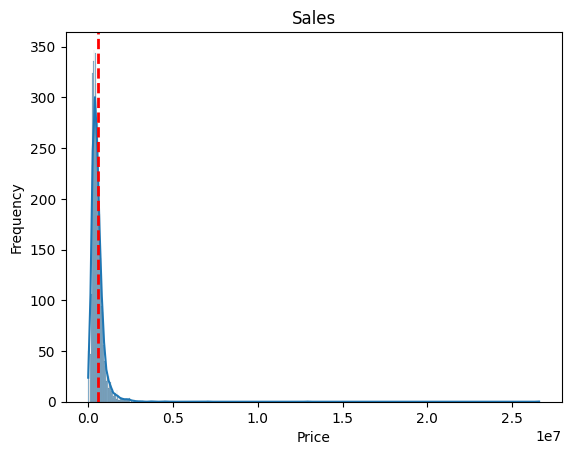

In [3]:
#checking the target variables for distribution
sns.histplot(df['price'], kde=True)
plt.axvline(x=df['price'].mean(), linestyle='--', linewidth=2, color='red')
plt.title('Sales')  
plt.xlabel('Price')
plt.ylabel('Frequency')
plt.show()

the plot shows that there's a somewhat left skew to the graph, accompanied by infrequent outliers which necessitate scaling

In [4]:

#describe df to get a better overview
df.describe()
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4600 entries, 0 to 4599
Data columns (total 18 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   date           4600 non-null   object 
 1   price          4600 non-null   float64
 2   bedrooms       4600 non-null   float64
 3   bathrooms      4600 non-null   float64
 4   sqft_living    4600 non-null   int64  
 5   sqft_lot       4600 non-null   int64  
 6   floors         4600 non-null   float64
 7   waterfront     4600 non-null   int64  
 8   view           4600 non-null   int64  
 9   condition      4600 non-null   int64  
 10  sqft_above     4600 non-null   int64  
 11  sqft_basement  4600 non-null   int64  
 12  yr_built       4600 non-null   int64  
 13  yr_renovated   4600 non-null   int64  
 14  street         4600 non-null   object 
 15  city           4600 non-null   object 
 16  statezip       4600 non-null   object 
 17  country        4600 non-null   object 
dtypes: float

In [5]:
# dealing with missing data and min-max scaling

#'dropping' the 0 rows- as we would be unable to form any coherent predictions from them
df = df[df['price'] != 0]


df['date'] = pd.to_datetime(df['date'])
df['years_since_renovation'] = np.where(df['yr_renovated'] == 0, 0, df['date'].dt.year - df['yr_renovated'])
df['house_age'] = df['date'].dt.year - df['yr_built']
df['date'] = (df['date'].astype('int64') / (24 * 3600)).round() * (24 * 3600)

df[['zipstring', 'zipcode']] = df['statezip'].str.split(' ', expand=True)
df.drop(columns= ['street','statezip', 'zipstring', 'country'], inplace= True)


In [6]:
from sklearn.impute import SimpleImputer

num_cols = [col for col in df.columns if df[col].dtype in ['float64','int64']]
cat_cols = [col for col in df.columns if df[col].dtype not in ['float64','int64']]

df[num_cols] = SimpleImputer().fit_transform(df[num_cols])
df[num_cols] = MinMaxScaler().fit_transform(df[num_cols])
encoder = OneHotEncoder(handle_unknown='ignore', sparse_output = False).fit(df[cat_cols])
encoded_cols = list(encoder.get_feature_names_out(cat_cols))
df_encoded = pd.DataFrame(
    encoder.fit_transform(df[cat_cols]), 
    columns=encoder.get_feature_names_out(cat_cols), 
    index=df.index
)

df = pd.concat([df.drop(columns=cat_cols), df_encoded], axis=1)

          date     price  bedrooms  bathrooms  sqft_living  sqft_lot  floors  \
0     0.000000  0.011481  0.333333    0.18750     0.073652  0.006775     0.2   
1     0.000000  0.089391  0.555556    0.31250     0.249051  0.007835     0.4   
2     0.000000  0.012572  0.333333    0.25000     0.118451  0.010534     0.0   
3     0.000000  0.015507  0.333333    0.28125     0.123766  0.006885     0.0   
4     0.000000  0.020397  0.444444    0.31250     0.119210  0.009186     0.0   
...        ...       ...       ...        ...          ...       ...     ...   
4595  0.985507  0.011300  0.333333    0.21875     0.086560  0.005330     0.0   
4596  0.985507  0.019808  0.333333    0.31250     0.082764  0.006460     0.4   
4597  0.985507  0.015390  0.333333    0.31250     0.200456  0.005939     0.4   
4598  1.000000  0.007358  0.444444    0.25000     0.130600  0.005581     0.0   
4599  1.000000  0.008005  0.333333    0.31250     0.085042  0.006952     0.4   

      waterfront  view  condition  ... 

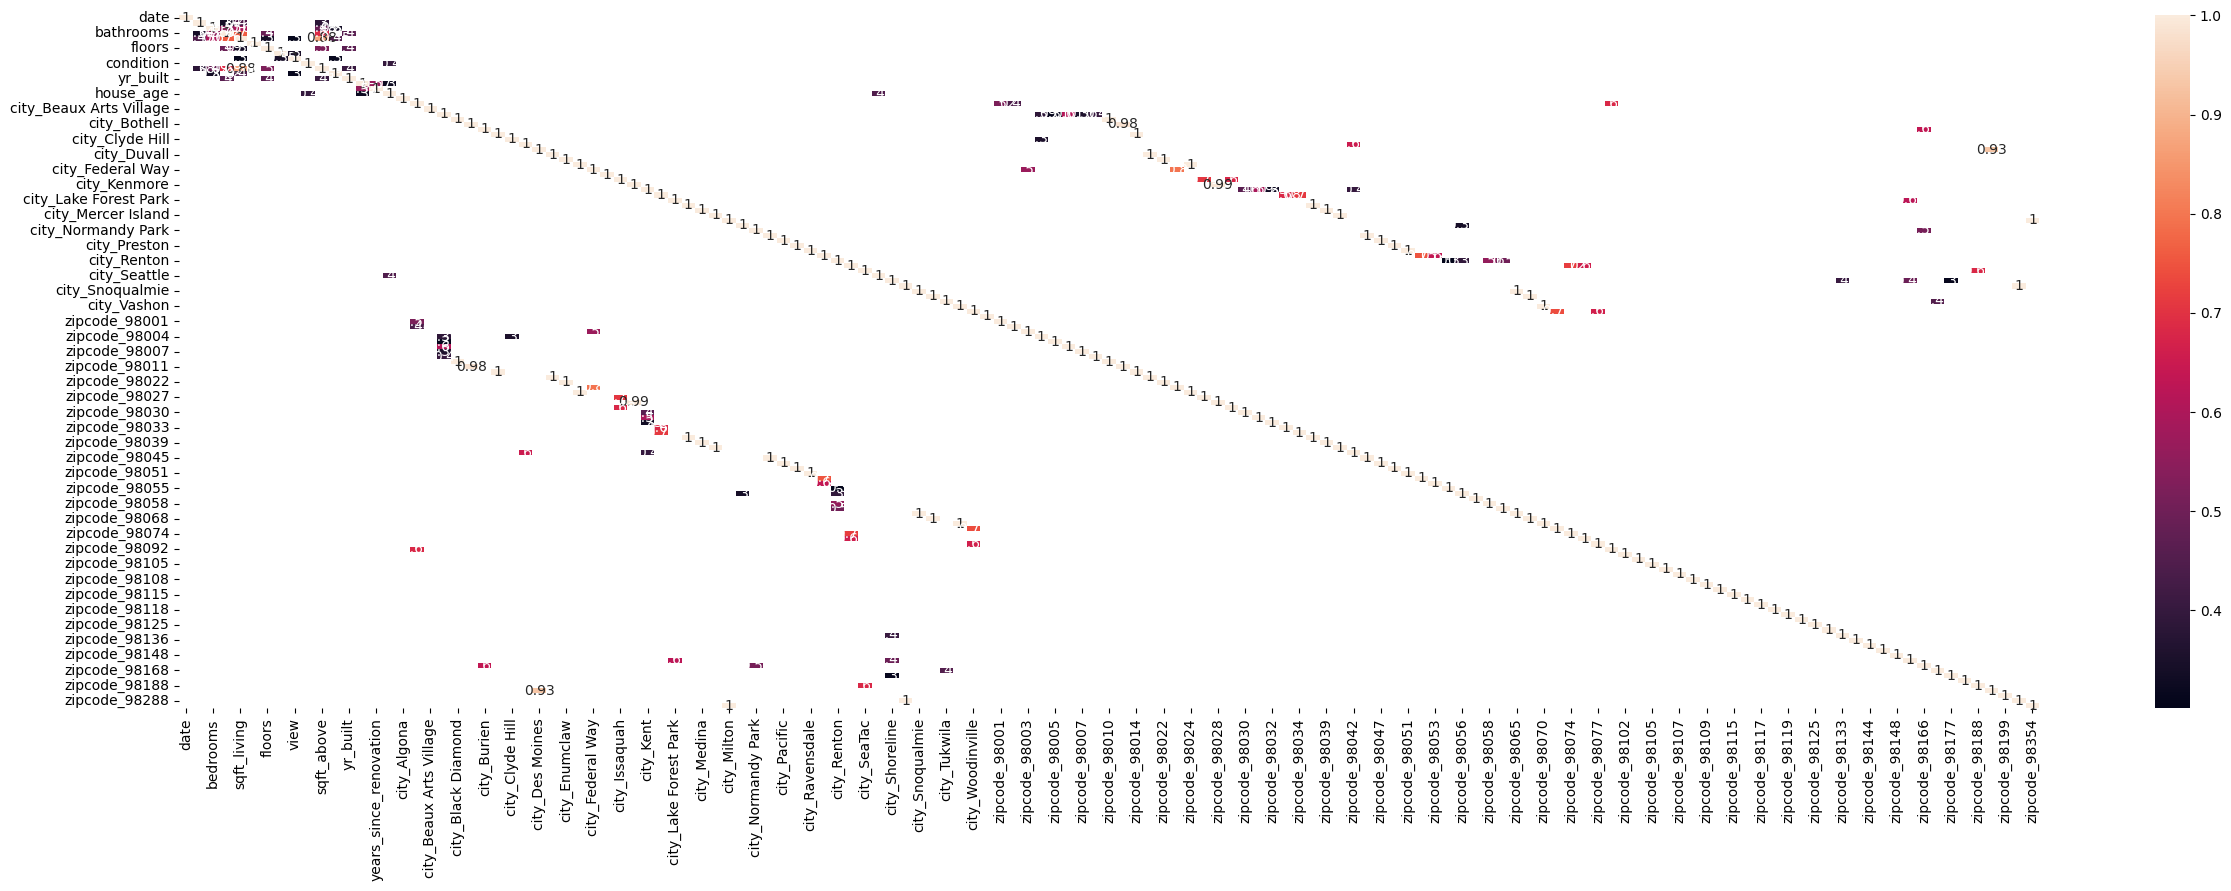

In [7]:

#using .corr() to identify areas/data with highest corellation
corr = df.corr()
corr_filtered = corr.where(corr >= 0.3, np.nan)
# Identify columns where all correlations are below 0.3
cols_to_drop = [col for col in corr_filtered.columns if corr_filtered[col].isna().all()]
df_cleaned = df.drop(columns=cols_to_drop)

# Print the cleaned data
print(df_cleaned)

# Optionally, plot the heatmap again with the filtered correlations
plt.figure(figsize=(30, 9))
sns.heatmap(corr_filtered, annot=True)
# Save the heatmap as a JPG file
plt.savefig('heatmap.jpg', format='jpg')


In [8]:
y = df_cleaned['price']
X = df_cleaned.drop('price', axis=1)  # All columns except 'price'


using OneHotEncoder for strings-> narrow down data

see https://www.reddit.com/r/datascience/comments/145d04o/label_encoding_for_categorical_columns_xgboost/

In [9]:
X_train,X_test,y_train,y_test = train_test_split(X,
                                                 y,
                                                 test_size=0.2,
                                                 random_state=42)

In [10]:
num_cols.remove('price')
X_train[num_cols] = SimpleImputer().fit_transform(X_train[num_cols])
X_train[num_cols] = MinMaxScaler().fit_transform(X_train[num_cols])
X_test[num_cols] = SimpleImputer().fit_transform(X_test[num_cols])
X_test[num_cols] = MinMaxScaler().fit_transform(X_test[num_cols])

In [12]:
# copypasted optimizing
import optuna


'''

def objective(trial, data = inputs_df[numeric_cols + encoded_cols],target = targets):
    
    #x, y = inputs_df[numeric_cols + encoded_cols], targets
    X_train,X_test,y_train,y_test = train_test_split(
    inputs_df[numeric_cols + encoded_cols], targets, test_size=0.25, random_state=42)
    param = {
        'tree_method':'gpu_hist',  # this parameter means using the GPU when training our model to speedup the training process
        'lambda': trial.suggest_loguniform('lambda', 1e-3, 10.0),
        'alpha': trial.suggest_loguniform('alpha', 1e-3, 10.0),
        'colsample_bytree': trial.suggest_categorical('colsample_bytree', [0.3,0.4,0.5,0.6,0.7,0.8,0.9, 1.0]),
        'subsample': trial.suggest_categorical('subsample', [0.4,0.5,0.6,0.7,0.8,1.0]),
        'learning_rate': trial.suggest_categorical('learning_rate', [0.008,0.009,0.01,0.012,0.014,0.016,0.018, 0.02]),
        'n_estimators': trial.suggest_categorical('n_estimators', [1000,2000,3000,4000]),
        'max_depth': trial.suggest_categorical('max_depth', [5,7,9,11,13,15,17,20]),
        'random_state': trial.suggest_categorical('random_state', [24, 48,2020]),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 300),
    }
    model = XGBRegressor(**param)  
    
    model.fit(X_train, y_train, eval_set=[(X_test, y_test)], early_stopping_rounds=100, verbose=False)
    preds_valid = model.predict(X_test)
    rmse = mean_squared_error(y_test, preds_valid, squared=False)
    return rmse

    
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=50)

study.best_params

'''
#taking best params
best_params = {'lambda': 3.559040735218393,
 'alpha': 0.25772549522868987,
 'colsample_bytree': 0.6,
 'subsample': 0.5,
 'learning_rate': 0.014,
 'n_estimators': 4000,
 'max_depth': 11,
 'random_state': 24,
 'min_child_weight': 3}


c:\Users\darie\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [13]:

#making dictionary of models
models = {
    'SVR':SVR(),
    'XGBRegressor':XGBRegressor(),
    'XGBR':XGBRegressor(**best_params),
    'Ridge':Ridge(),
    'ElasticNet':ElasticNet(),
    'SGDRegressor':SGDRegressor(),
    'BayesianRidge':BayesianRidge(),
    'LinearRegression':LinearRegression(),
    'RandomForestRegressor':RandomForestRegressor(),
    'GradientBoosting': GradientBoostingRegressor()
}

In [14]:
#taking results from the models
results = []

for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    rmse = mse**0.5
    r2 = r2_score(y_test, y_pred)
    results.append([name, r2, mse, rmse])

results_df = pd.DataFrame(results, columns=['Model', 'R-squared', 'MSE', 'RMSE'])
results_df = results_df.sort_values(by='R-squared', ascending=False).reset_index(drop=True)
print(results_df)

                   Model  R-squared       MSE      RMSE
0          BayesianRidge   0.586717  0.000087  0.009328
1                  Ridge   0.568915  0.000091  0.009527
2       LinearRegression   0.562818  0.000092  0.009594
3           SGDRegressor   0.549725  0.000095  0.009737
4                   XGBR   0.365598  0.000134  0.011557
5             ElasticNet  -0.000021  0.000211  0.014510
6  RandomForestRegressor  -0.195071  0.000252  0.015862
7       GradientBoosting  -0.528269  0.000322  0.017938
8           XGBRegressor  -2.226519  0.000679  0.026064
9                    SVR -23.248393  0.005105  0.071451


from this, we can conclusively say that the most accurate model in this case would be BayesianRidge, with highest r-squared and lowest MSE/RMSE

Credit: 
https://www.kaggle.com/code/heyrobin/house-price-prediction-beginner-s-notebook
